# ДЗ

Задание на кластеризацию, понижение размерности и классификацию.

Мы будем работать с набором данных [Samsung Human Activity Recognition](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones). Скачайте данные [отсюда](https://drive.google.com/file/d/14RukQ0ylM2GCdViUHBBjZ2imCaYcjlux/view?usp=sharing). Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3 (подробнее про признаки – по ссылке на UCI выше), также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице. 

Вначале мы представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков. Затем решим задачу определения вида физической активности именно как задачу классификации.

In [45]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.colors import ListedColormap

%matplotlib inline


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

import gc

sns.set()
%matplotlib inline

import sys
# np.set_printoptions(suppress=True)
# np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column', 100) # None)
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 17

In [46]:
X_train = np.loadtxt("samsung_train.txt")
y_train = np.loadtxt("samsung_train_labels.txt").astype(int)

X_test = np.loadtxt("samsung_test.txt")
y_test = np.loadtxt("samsung_test_labels.txt").astype(int)

In [47]:
# Проверим размерности
assert(X_train.shape == (7352, 561) and y_train.shape == (7352,))
assert(X_test.shape == (2947, 561) and y_test.shape == (2947,))

Для кластеризации нам не нужен вектор ответов, поэтому будем работать с объединением обучающей и тестовой выборок. Объедините *X_train* с *X_test*, а *y_train* – с *y_test*. 

In [48]:
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [49]:
assert(X.shape == (10299, 561) and y.shape == (10299,))

Определим число уникальных значений меток целевого класса.

In [50]:
n_classes = np.unique(y).size

[Эти метки соответствуют:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - ходьбa
- 2 - подъем вверх по лестнице
- 3 - спуск по лестнице
- 4 - сидит
- 5 - стоит
- 6 - лежит



Отмасштабируйте выборку с помощью `StandardScaler` с параметрами по умолчанию.

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state (константа RANDOM_STATE).

In [52]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

**Вопрос 1:**<br>
Какое минимальное число главных компонент нужно выделить, чтобы объяснить 90% дисперсии исходных (отмасштабированных) данных?

In [53]:
pca.n_components_

65

**Вопрос 2:**<br>
Сколько процентов дисперсии приходится на первую главную компоненту? Округлите до целых процентов.

In [54]:
round(pca.explained_variance_ratio_[0] * 100)

51

Визуализируйте данные в проекции на первые две главные компоненты.

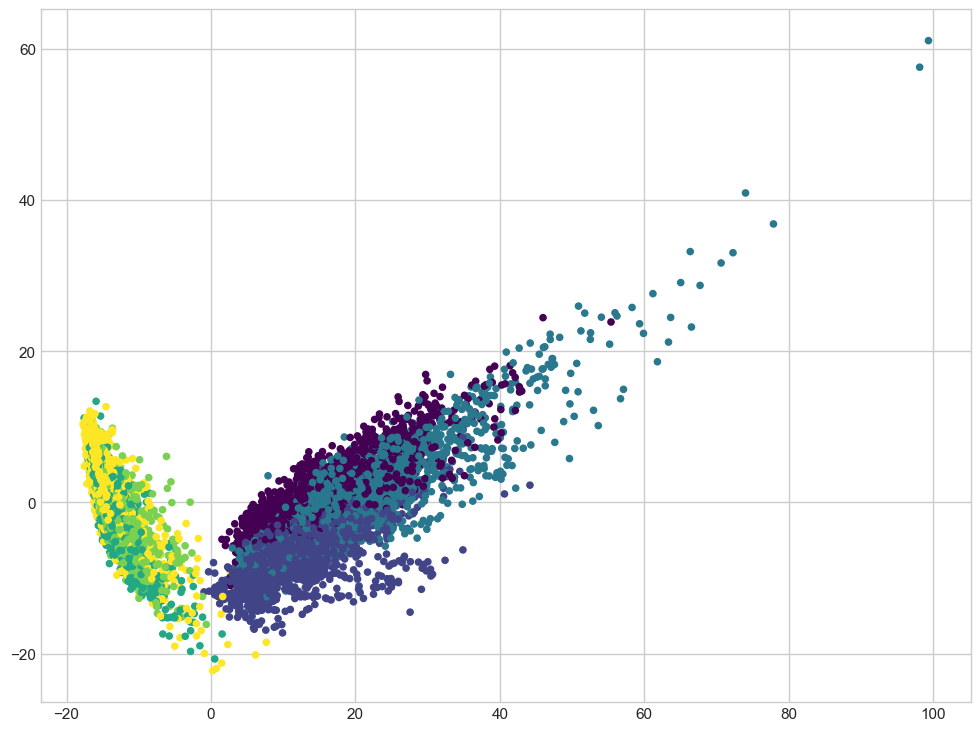

In [55]:
plt.scatter(X_pca[:, 0], X_pca[:, 1] , c=y, s=20, cmap='viridis');

**Вопрос 3:**<br>
Если все получилось правильно, Вы увидите сколько-то кластеров, почти идеально отделенных друг от друга. Какие виды активности входят в эти кластеры?<br>

**Ответ:**
  2 кластера: (ходьба, подъем вверх по лестнице, спуск по лестнице) и (сидение, стояние, лежание)

------------------------------

In [62]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE).fit(X_pca)
cluster_labels = kmeans.labels_

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

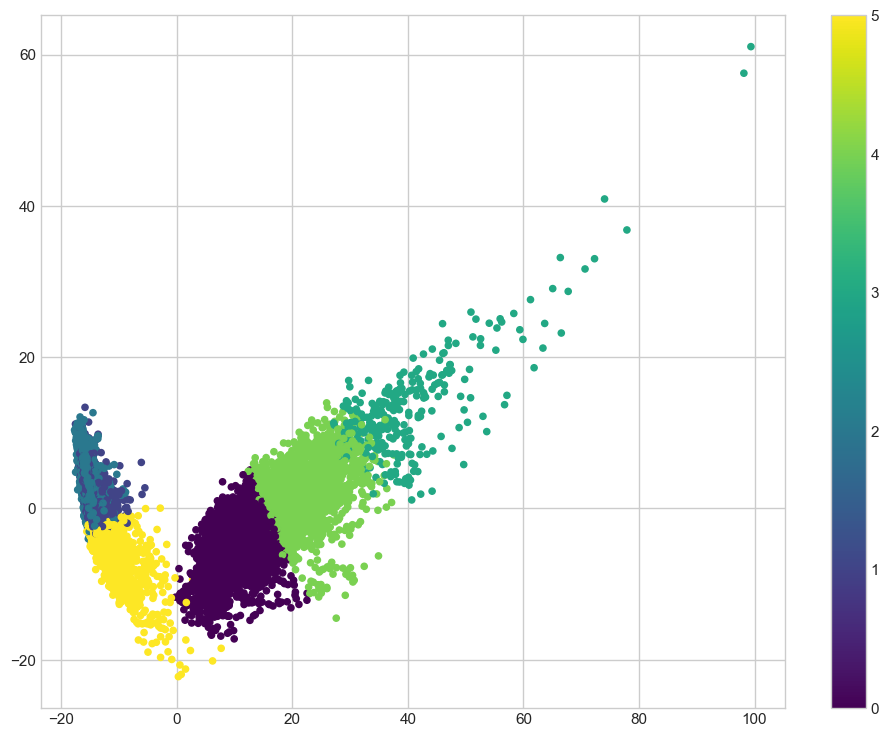

In [57]:
plt.scatter(X_pca[:, 0], X_pca[:, 1] , c=cluster_labels, s=20,  cmap='viridis')
plt.colorbar()

Посмотрите на соответствие между метками кластеров и исходными метками классов и на то, какие виды активностей алгоритм `KMeans` путает.

In [58]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 
             'спуск по лестнице', 'сидение', 'стояние', 'лежание', 'все']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['все']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,все
ходьба,903,0,0,78,741,0,1722
подъем вверх по лестнице,1241,0,0,5,296,2,1544
спуск по лестнице,320,0,0,196,890,0,1406
сидение,1,1235,91,0,0,450,1777
стояние,0,1344,0,0,0,562,1906
лежание,5,52,1558,0,0,329,1944
все,2470,2631,1649,279,1927,1343,10299


In [59]:
tab.iloc[:-1, :-1].max(axis=1) / tab.iloc[:-1, -1]


ходьба                      0.524390
подъем вверх по лестнице    0.803756
спуск по лестнице           0.633001
сидение                     0.694992
стояние                     0.705142
лежание                     0.801440
dtype: float64


**Вопрос 4:**<br>
Какой вид активности отделился от остальных лучше всего в терминах простой  метрики, описанной выше?<br>

**Ответ:**
- перечисленные варианты не подходят

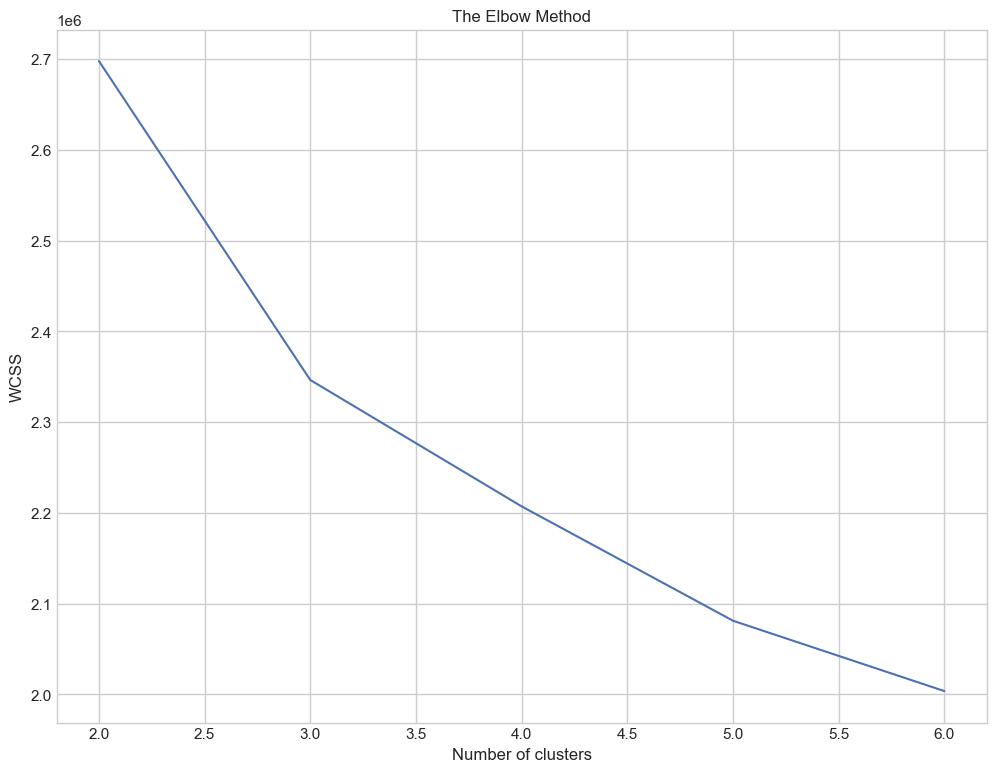

In [70]:
wcss = []
for i in range(2, 7):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 7), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



**Вопрос 5:**<br>
Какое количество кластеров оптимально выбрать, согласно методу локтя?<br>

**Ответ:**
- 2

------------------------

Попробуем еще один метод кластеризации, который описывался в статье – агломеративную кластеризацию.

In [ ]:
ag = AgglomerativeClustering(n_clusters=n_classes, 
                             linkage='ward').fit(X_pca)


In [71]:
X_ag = kmeans.fit_transform(X_pca)

Посчитайте Adjusted Rand Index (`sklearn.metrics`) для получившегося разбиения на кластеры и для `KMeans` с параметрами из задания к 4 вопросу.

In [72]:
from sklearn.metrics.cluster import adjusted_rand_score

kmeans_score = adjusted_rand_score(y, kmeans.labels_)
ag_score = adjusted_rand_score(y, ag.labels_)

print(kmeans_score)
print(ag_score)

0.4195934235115518
0.49362763373004886


**Вопрос 6:**<br>
Отметьте все верные утверждения.<br>

**Ответ:** все верно

-------------------------------

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}

In [76]:
model = GridSearchCV(svc, param_grid=svc_params, verbose=2,  cv=3).fit(X_train_scaled, y_train)
best_svc = model.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ............................................C=0.001; total time=   8.5s
[CV] END ............................................C=0.001; total time=   3.8s
[CV] END ............................................C=0.001; total time=   6.9s
[CV] END .............................................C=0.01; total time=   6.6s
[CV] END .............................................C=0.01; total time=   5.4s
[CV] END .............................................C=0.01; total time=   6.7s
[CV] END ..............................................C=0.1; total time=   7.8s
[CV] END ..............................................C=0.1; total time=   8.1s
[CV] END ..............................................C=0.1; total time=   7.9s
[CV] END ................................................C=1; total time=   7.3s
[CV] END ................................................C=1; total time=   5.6s
[CV] END ........................................

**Вопрос 7**<br>
Какое значение гиперпараметра `C` было выбрано лучшим по итогам кросс-валидации?<br>

In [77]:
print(model.best_params_)

{'C': 0.1}


In [78]:
y_predicted = best_svc.predict(X_test_scaled)

In [79]:
tab = pd.crosstab(y_test, y_predicted, margins=True)
tab.index = ['ходьба', 'подъем вверх по лестнице', 'спуск по лестнице', 
             'сидение', 'стояние', 'лежание', 'все']
tab.columns = tab.index
tab

,ходьба,подъем вверх по лестнице,спуск по лестнице,сидение,стояние,лежание,все
ходьба,494,2,0,0,0,0,496
подъем вверх по лестнице,12,459,0,0,0,0,471
спуск по лестнице,2,3,414,1,0,0,420
сидение,0,4,0,426,61,0,491
стояние,0,0,0,15,517,0,532
лежание,0,0,0,0,11,526,537
все,508,468,414,442,589,526,2947


In [80]:
print(metrics.classification_report(y_test, y_predicted, target_names=tab.index[:6]))

                          precision    recall  f1-score   support

                  ходьба       0.97      1.00      0.98       496
подъем вверх по лестнице       0.98      0.97      0.98       471
       спуск по лестнице       1.00      0.99      0.99       420
                 сидение       0.96      0.87      0.91       491
                 стояние       0.88      0.97      0.92       532
                 лежание       1.00      0.98      0.99       537

                accuracy                           0.96      2947
               macro avg       0.97      0.96      0.96      2947
            weighted avg       0.96      0.96      0.96      2947



**Вопрос 8:**<br>
Какой вид активности SVM определяет хуже всего в терминах точности? Полноты? <br>

**Ответ:** нет верного ответа -- по точности – стояние, по полноте – сидение
- по точности – подъем вверх по лестнице, по полноте – лежание
- по точности – лежание, по полноте – сидение
- по точности – ходьба, по полноте – ходьба
- по точности – сидение, по полноте – стояние


**Вопрос 9:**<br>
Какова разность между лучшим качеством (долей верных ответов) на кросс-валидации в случае всех 561 исходных признаков и во втором случае, когда применялся метод главных компонент? Округлите до целых процентов.<br>

**Ответ:**
- Качество одинаковое


In [81]:
pca = PCA().fit(X_train_scaled)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(svc, param_grid=svc_params, cv=3).fit(X_train_pca, y_train)
print(grid.best_score_)
print(model.best_score_)


0.9382506099134881
0.9382506099134881


**Вопрос 10:**<br>
Выберите все верные утверждения:

**Ответ:**
- PCA можно использовать для визуализации данных, однако для этой задачи есть и лучше подходящие методы, например, tSNE. Зато PCA имеет меньшую вычислительную сложность
- PCA строит линейные комбинации исходных признаков, и в некоторых задачах они могут плохо интерпретироваться человеком